In [29]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

/var/folders/c8/10s2rfzn0_q5g9s2dmcv8hb80000gn/T/ipykernel_77708/141191317.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [30]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
SEQUENCE_LENGTH = 16
 

DATASET_DIR = "/Users/vamsikeshwaran/Desktop/TrimedDataset/Train"
 
CLASSES_LIST = ["Abuse","Assault","Fighting", "Normal"]

In [31]:
def frames_extraction(video_path):
 
    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)
 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    for frame_counter in range(SEQUENCE_LENGTH):
 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
    
 
    video_reader.release()
 
    return frames_list

In [32]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            frames = frames_extraction(video_file_path)
 
            if len(frames) == SEQUENCE_LENGTH:
 
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [33]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Abuse
Extracting Data of Class: Assault
Extracting Data of Class: Fighting
Extracting Data of Class: Normal


In [34]:
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [35]:
one_hot_encoded_labels = to_categorical(labels)

In [36]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [37]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(377, 16, 64, 64, 3) (377, 4)
(42, 16, 64, 64, 3) (42, 4)


In [38]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False


In [39]:
def create_model():
 
    model = Sequential()

    
    
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(mobilenet))
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    
 
    model.summary()
    
    return model

In [40]:
MoBiLSTM_model = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 16, 2, 2, 1280)    2257984   
 stributed)                                                      
                                                                 
 dropout_6 (Dropout)         (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                1319168   
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                      

In [41]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
 
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
 
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
38/38 [==============================] - 10s 204ms/step - loss: 1.3965 - accuracy: 0.2890 - val_loss: 1.3807 - val_accuracy: 0.3026 - lr: 0.0100
Epoch 2/50
38/38 [==============================] - 6s 165ms/step - loss: 1.3911 - accuracy: 0.2990 - val_loss: 1.3746 - val_accuracy: 0.3158 - lr: 0.0100
Epoch 3/50
38/38 [==============================] - 7s 179ms/step - loss: 1.3672 - accuracy: 0.3223 - val_loss: 1.3754 - val_accuracy: 0.2763 - lr: 0.0100
Epoch 4/50
38/38 [==============================] - 7s 180ms/step - loss: 1.3768 - accuracy: 0.2658 - val_loss: 1.3745 - val_accuracy: 0.2763 - lr: 0.0100
Epoch 5/50
38/38 [==============================] - 7s 180ms/step - loss: 1.3747 - accuracy: 0.2924 - val_loss: 1.3724 - val_accuracy: 0.3026 - lr: 0.0100
Epoch 6/50
38/38 [==============================] - 7s 190ms/step - loss: 1.3441 - accuracy: 0.3189 - val_loss: 1.3722 - val_accuracy: 0.2895 - lr: 0.0100
Epoch 7/50
38/38 [==============================] - 7s 189ms/step - l

In [42]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

2/2 [==============================] - 1s 132ms/step - loss: 1.0587 - accuracy: 0.5952


In [43]:
import matplotlib.pyplot as plt

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
 
    plt.title(str(plot_name))
    plt.xlabel("Epochs")
    plt.ylabel(metric_name_1.split('_')[0].capitalize())
    plt.legend()
    plt.show()

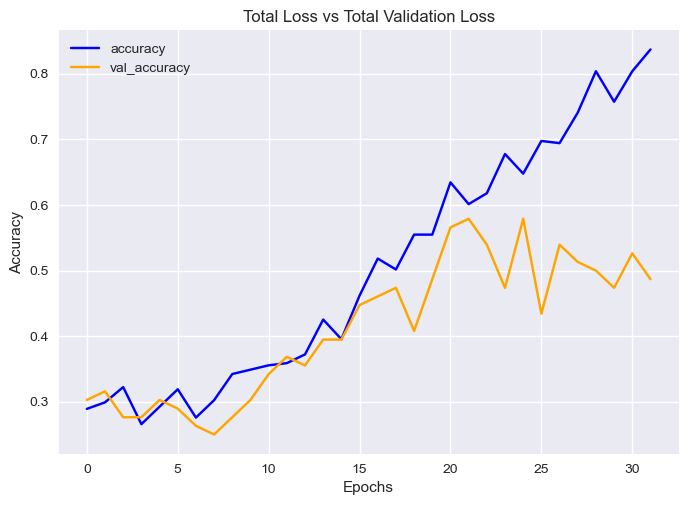

In [44]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

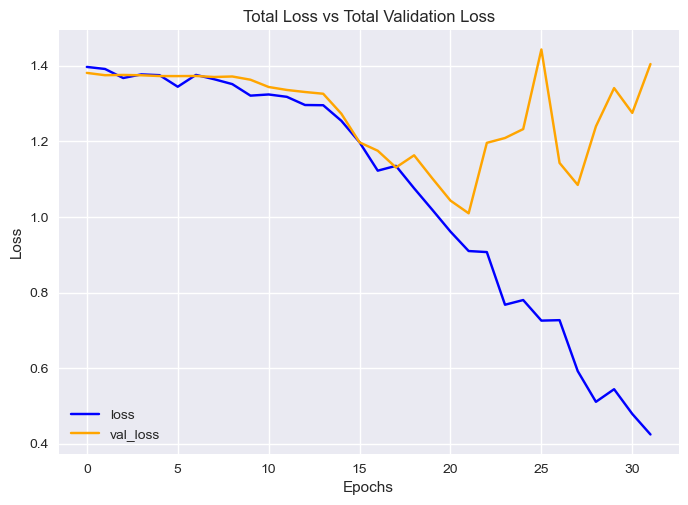

In [45]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [46]:
labels_predict = MoBiLSTM_model.predict(features_test)

2/2 [==============================] - 1s 109ms/step


In [47]:
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [48]:
labels_test_normal.shape , labels_predict.shape

((42,), (42,))

In [49]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.5952380952380952


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (2).

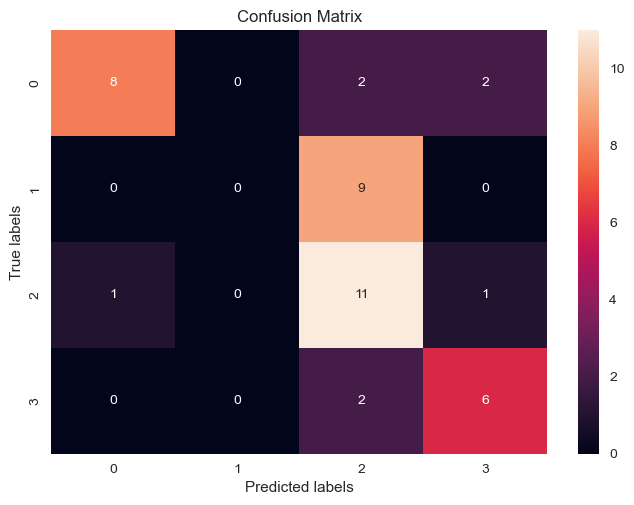

In [50]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [51]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.00      0.00      0.00         9
           2       0.46      0.85      0.59        13
           3       0.67      0.75      0.71         8

    accuracy                           0.60        42
   macro avg       0.50      0.57      0.52        42
weighted avg       0.52      0.60      0.54        42



/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    video_reader = cv2.VideoCapture(video_file_path)
 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    predicted_class_name = ''
 
    while video_reader.isOpened():
 
        ok, frame = video_reader.read() 
        
        if not ok:
            break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
 
        frames_queue.append(normalized_frame)
 

        if len(frames_queue) == SEQUENCE_LENGTH:                        
 
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        video_writer.write(frame)                       
        
    video_reader.release()
    video_writer.release()

In [53]:
plt.style.use("default")

def show_pred_frames(pred_video_path): 

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))
        
    for counter, random_index in enumerate(random_range, 1):
        
        plt.subplot(5, 4, counter)

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
          
        ok, frame = video_reader.read() 

        if not ok:
          break 

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()
                            
    video_reader.release()


In [54]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


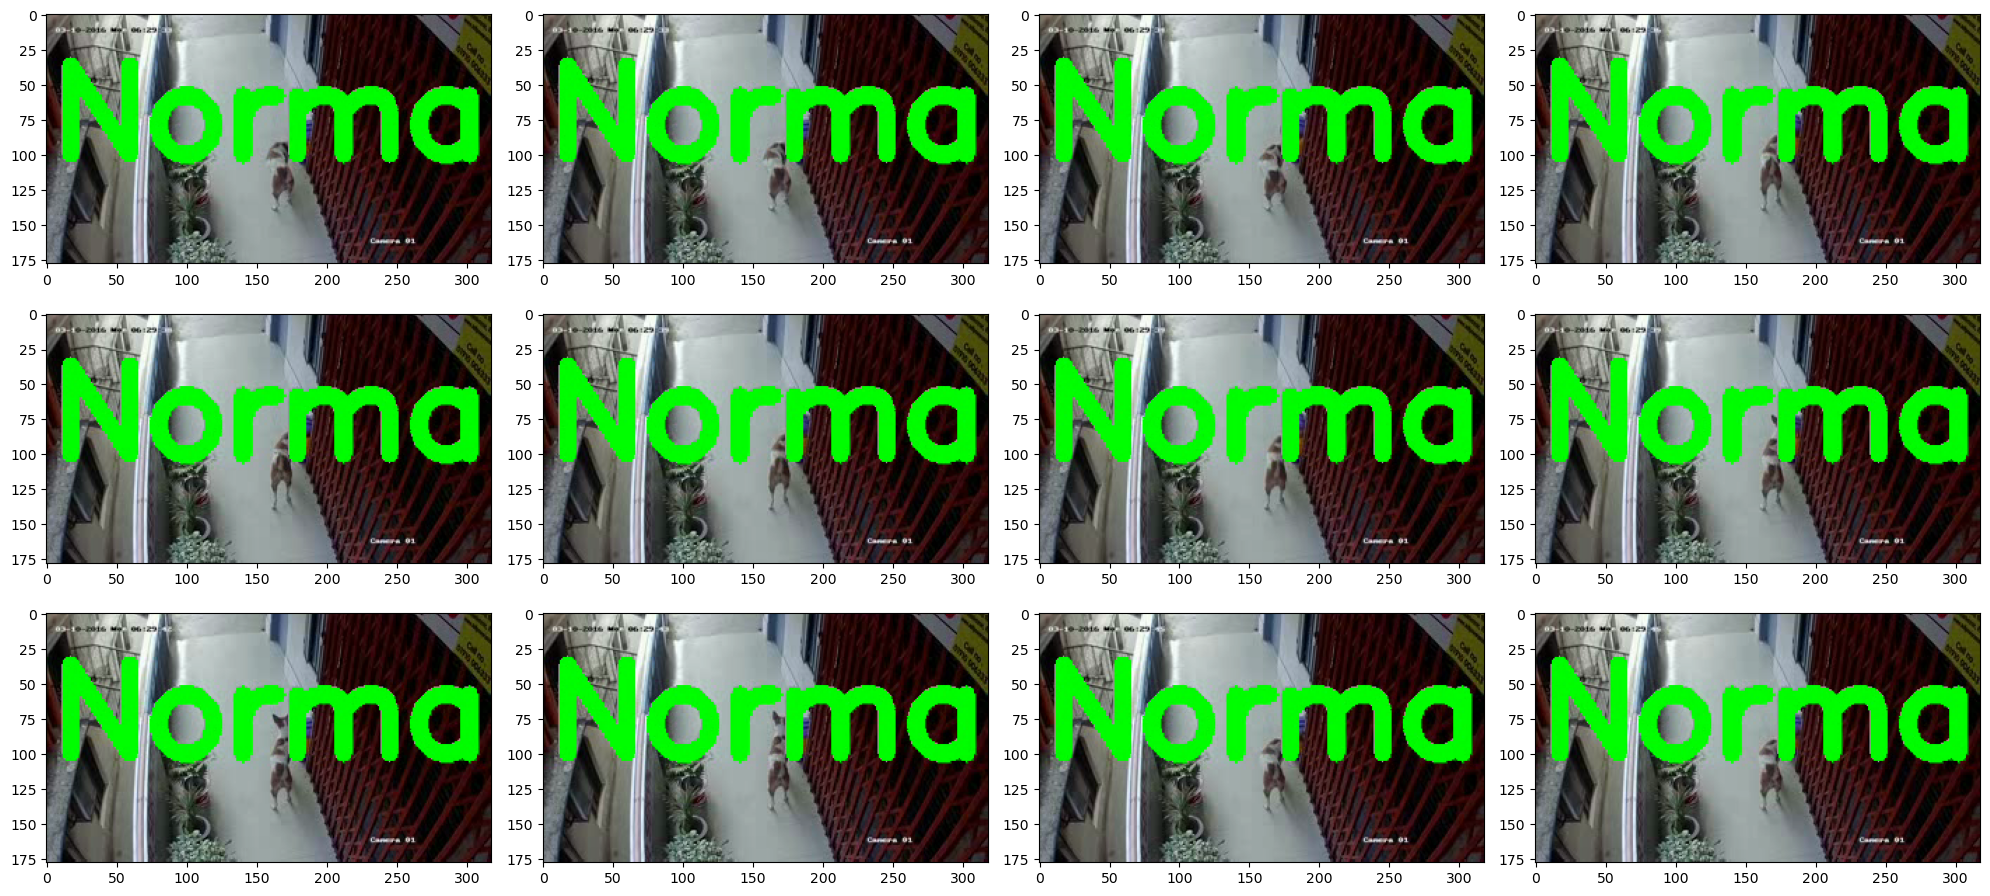

In [56]:
input_video_file_path = "/Users/vamsikeshwaran/Desktop/TrimedDataset/Test/Normal/Normal1.mp4"

predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

show_pred_frames(output_video_file_path)

In [69]:
MoBiLSTM_model.save('abuseat.h5')